In [152]:
import os
import scanpy as sc
import re
from pathlib import Path

import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tifffile
from tifffile import TiffFile
from ome_types import from_tiff, from_xml
from sklearn.preprocessing import StandardScaler

In [153]:
import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 120
# mpl.rcParams['figure.figsize'] = (6, 5)

In [3]:
out_dir = '/data/multiplex/codex_inhouse/codex/HT206B1-H1/analysis/'
Path(out_dir).mkdir(parents=True, exist_ok=True)
sc.settings.figdir = out_dir

In [4]:
ome_fp = '/data/multiplex/codex_inhouse/codex/HT206B1-H1/ome_tiff/HT206B1-H1.ome.tiff'

In [5]:
def get_channels(fp):   
    tif = TiffFile(fp)
    ome = from_xml(tif.ome_metadata)
    im = ome.images[0]
    return [channel.name for channel in im.pixels.channels]

def extract_htan_ome_tiff(fp):   
    tif = TiffFile(fp)
    ome = from_xml(tif.ome_metadata)
    im = ome.images[0]
    d = {}
    for c, p in zip(im.pixels.channels, tif.pages):
        img = p.asarray()
        d[c.name] = img
    return d

def merge_channels(channel_to_img, channels):
    img = None
    for c in channels:
        X = np.expand_dims(channel_to_img[c], 0)
        if img is None:
            img = X
        else:
            X = np.concatenate((img, X))
    return np.mean(img, axis=0)

In [6]:
channel_to_img = extract_htan_ome_tiff(ome_fp)

In [7]:
channel_to_img.keys()

dict_keys(['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-CK', 'CD8', 'Histone H3 Pho', 'CD163', 'Podoplanin', 'CD3', 'CD36', 'HIF1a', 'GLUT1', 'GATA3', 'CD45RO', 'CD45RA', 'SMA', 'CK19', 'MGP', 'Vimentin', 'Maspin', 'Foxp3', 'MMP9', 'HLA-DR', 'CK14', 'CD11c', 'CD44'])

In [12]:
df = pd.read_csv('/data/multiplex/codex_inhouse/codex/HT206B1-H1/exports/HT206B1_H1_ome_QiFeaturesToOrange.csv',
                index_col='Cell Id')
df

Nuc X         Nuc Y     Nuc Y Inv  Nucleus DNA Mean  \
Cell Id                                                              
1        3644.789551      1.421053  15118.579102      10248.368164   
2        3678.917480     17.010118  15102.990234      32956.292969   
3        3728.276367     11.302376  15108.697266      33309.664062   
4        3755.278076     12.594249  15107.405273      30201.232422   
5        3883.165771      8.068571  15111.931641      30217.531250   
...              ...           ...           ...               ...   
175731   9168.000000  15117.500000      2.500000      20659.699219   
175732   9217.380859  15117.238281      2.761905      22826.427734   
175733   9241.265625  15117.296875      2.703125      16787.015625   
175734   4270.210449  15117.579102      2.421053       7833.526367   
175735   6969.500000  15117.599609      2.400000       5233.700195   

         Nucleus DNA Excess Kurtosis  DAPI Cell Exp  DAPI Nuc/Cyto Ratio  \
Cell Id                                                                    
1                          -0.586154    8537.627930             1.362475   
2                          -0.130872   25043.285156             6.604162   
3                           0.011908   25740.919922             5.053362   
4                          -0.585292   24065.525391             4.937145   
5                          -0.814879   18907.542969             5.852976   
...                              ...            ...                  ...   
175731                     -0.684585   12297.391602             2.167179   
175732                     -0.200796   22372.257812             1.052346   
175733                     -0.501238   15167.479492             1.121458   
175734                      0.296150    8713.166992             0.765550   
175735                     -1.219526    4728.952148             1.164549   

         CD31 Cell Exp  CD31 Nuc/Cyto Ratio  E-cadherin Cell Exp  ...  \
Cell Id                                                           ...   
1           144.745102             0.604604          1546.450928  ...   
2           243.503632             0.194147          2711.743652  ...   
3           266.896271             0.208814          4204.828125  ...   
4           286.669037             0.661216          4899.847656  ...   
5           282.263336             0.115916          4667.109863  ...   
...                ...                  ...                  ...  ...   
175731      365.608704             0.789412          1394.844727  ...   
175732      203.428574             0.558912           711.942871  ...   
175733      514.058044             1.480183          2338.153564  ...   
175734      224.266663             1.905209           551.433350  ...   
175735      342.809509             0.630619           830.761902  ...   

         MMP9 Cell Exp  MMP9 Nuc/Cyto Ratio  HLA-DR Cell Exp  \
Cell Id                                                        
1           355.725494             1.165001        71.352943   
2           762.905090             4.766403       269.880280   
3           591.868408             3.908751       221.467499   
4           554.077393             2.451555       380.095245   
5           457.084625             1.150479       182.946701   
...                ...                  ...              ...   
175731     1209.403687             1.168077       722.167725   
175732     2038.971436             0.859232       798.028564   
175733     2567.817383             1.100479      7205.000000   
175734      882.166687             0.862023       562.633362   
175735      895.015869             0.887810      1206.698364   

         HLA-DR Nuc/Cyto Ratio  CK14 Cell Exp  CK14 Nuc/Cyto Ratio  \
Cell Id                                                              
1                     1.106701   41773.648438             1.068959   
2                     0.469894   41326.871094             0.665495   
3                     0.648813   48691.925781       

In [18]:
keep = [
    'Nuc X',
    'Nuc Y',
]
marker_keep = [
    'Cell Exp',
]
for col in marker_keep:
    keep += [c for c in df.columns
             if col in c
             if '.' not in c]
keep

['Nuc X',
 'Nuc Y',
 'DAPI Cell Exp',
 'CD31 Cell Exp',
 'E-cadherin Cell Exp',
 'CD4 Cell Exp',
 'CD20 Cell Exp',
 'Ki67 Cell Exp',
 'CD68 Cell Exp',
 'Pan-CK Cell Exp',
 'CD8 Cell Exp',
 'Histone H3 Pho Cell Exp',
 'CD163 Cell Exp',
 'Podoplanin Cell Exp',
 'CD3 Cell Exp',
 'CD36 Cell Exp',
 'HIF1a Cell Exp',
 'GLUT1 Cell Exp',
 'GATA3 Cell Exp',
 'CD45RO Cell Exp',
 'CD45RA Cell Exp',
 'SMA Cell Exp',
 'CK19 Cell Exp',
 'MGP Cell Exp',
 'Vimentin Cell Exp',
 'Maspin Cell Exp',
 'Foxp3 Cell Exp',
 'MMP9 Cell Exp',
 'HLA-DR Cell Exp',
 'CK14 Cell Exp',
 'CD11c Cell Exp',
 'CD44 Cell Exp']

In [19]:
df = df[keep]
df

Nuc X         Nuc Y  DAPI Cell Exp  CD31 Cell Exp  \
Cell Id                                                            
1        3644.789551      1.421053    8537.627930     144.745102   
2        3678.917480     17.010118   25043.285156     243.503632   
3        3728.276367     11.302376   25740.919922     266.896271   
4        3755.278076     12.594249   24065.525391     286.669037   
5        3883.165771      8.068571   18907.542969     282.263336   
...              ...           ...            ...            ...   
175731   9168.000000  15117.500000   12297.391602     365.608704   
175732   9217.380859  15117.238281   22372.257812     203.428574   
175733   9241.265625  15117.296875   15167.479492     514.058044   
175734   4270.210449  15117.579102    8713.166992     224.266663   
175735   6969.500000  15117.599609    4728.952148     342.809509   

         E-cadherin Cell Exp  CD4 Cell Exp  CD20 Cell Exp  Ki67 Cell Exp  \
Cell Id                                                                    
1                1546.450928    755.039246    1215.196045   18133.587891   
2                2711.743652   1715.001221     768.243652   44888.597656   
3                4204.828125   1949.190430    7180.343750   15777.291016   
4                4899.847656   1710.984497    4092.289307   24038.171875   
5                4667.109863   2554.551758    4898.536133   27119.685547   
...                      ...           ...            ...            ...   
175731           1394.844727   1372.695679     100.416145   16297.578125   
175732            711.942871    817.200012    1154.971436   36647.113281   
175733           2338.153564   1884.989746    2229.058105    4759.725098   
175734            551.433350   2192.600098     133.433334     449.666656   
175735            830.761902    305.301575     133.301590     119.507935   

         CD68 Cell Exp  Pan-CK Cell Exp  ...  CK19 Cell Exp  MGP Cell Exp  \
Cell Id                                  ...                                
1           234.019608     20978.000000  ...    6513.098145  19313.431641   
2           612.114258     15914.724609  ...    8819.262695   9308.651367   
3           561.566589     22463.152344  ...   18338.734375  17483.740234   
4           713.446411     32619.968750  ...   29037.050781  23921.052734   
5           529.777405     19005.830078  ...    8124.567383   3110.598633   
...                ...              ...  ...            ...           ...   
175731      682.596252     10115.534180  ...    5696.776367   3388.354004   
175732     1091.714233      2427.514404  ...    2099.800049   7267.799805   
175733     1353.822510     12486.687500  ...    6385.126465   5738.389160   
175734     1062.833374        73.766670  ...     621.799988   1557.400024   
175735      963.539673        53.952381  ...     968.634949   1668.095215   

         Vimentin Cell Exp  Maspin Cell Exp  Foxp3 Cell Exp  MMP9 Cell Exp  \
Cell Id                                                                      
1               110.274513      4934.137207      726.921570     355.725494   
2               124.801086      6388.687012     1229.723755     762.905090   
3               176.507736      6584.266113     1393.616089     591.868408   
4               312.694061      7065.195312     1224.015503     554.077393   
5               107.228844      3704.887207     1124.219482     457.084625   
...                    ...              ...             ...            ...   
175731          200.888199      3553.919189     2345.192627    1209.403687   
175732          269.085724      6767.571289     2894.628662    2038.971436   
175733          278.667236      8087.245605     5416.375488    2567.817383   
175734           72.500000      1681.366699      360.533325     882.166687   
175735        17881.935547       661.015869      706.666687     895.015869   

         HLA-DR Cell Exp  CK14 Cell Exp  CD11c Cell Exp  CD44 Cell Exp  
Cell Id                                            

In [20]:
# get rid of cycle info if there
df.columns = [re.sub(r'^reg[0-9]+_cyc[0-9]+_ch[0-9]+_(.*)$', r'\1', c) for c in df.columns]
df

Nuc X         Nuc Y  DAPI Cell Exp  CD31 Cell Exp  \
Cell Id                                                            
1        3644.789551      1.421053    8537.627930     144.745102   
2        3678.917480     17.010118   25043.285156     243.503632   
3        3728.276367     11.302376   25740.919922     266.896271   
4        3755.278076     12.594249   24065.525391     286.669037   
5        3883.165771      8.068571   18907.542969     282.263336   
...              ...           ...            ...            ...   
175731   9168.000000  15117.500000   12297.391602     365.608704   
175732   9217.380859  15117.238281   22372.257812     203.428574   
175733   9241.265625  15117.296875   15167.479492     514.058044   
175734   4270.210449  15117.579102    8713.166992     224.266663   
175735   6969.500000  15117.599609    4728.952148     342.809509   

         E-cadherin Cell Exp  CD4 Cell Exp  CD20 Cell Exp  Ki67 Cell Exp  \
Cell Id                                                                    
1                1546.450928    755.039246    1215.196045   18133.587891   
2                2711.743652   1715.001221     768.243652   44888.597656   
3                4204.828125   1949.190430    7180.343750   15777.291016   
4                4899.847656   1710.984497    4092.289307   24038.171875   
5                4667.109863   2554.551758    4898.536133   27119.685547   
...                      ...           ...            ...            ...   
175731           1394.844727   1372.695679     100.416145   16297.578125   
175732            711.942871    817.200012    1154.971436   36647.113281   
175733           2338.153564   1884.989746    2229.058105    4759.725098   
175734            551.433350   2192.600098     133.433334     449.666656   
175735            830.761902    305.301575     133.301590     119.507935   

         CD68 Cell Exp  Pan-CK Cell Exp  ...  CK19 Cell Exp  MGP Cell Exp  \
Cell Id                                  ...                                
1           234.019608     20978.000000  ...    6513.098145  19313.431641   
2           612.114258     15914.724609  ...    8819.262695   9308.651367   
3           561.566589     22463.152344  ...   18338.734375  17483.740234   
4           713.446411     32619.968750  ...   29037.050781  23921.052734   
5           529.777405     19005.830078  ...    8124.567383   3110.598633   
...                ...              ...  ...            ...           ...   
175731      682.596252     10115.534180  ...    5696.776367   3388.354004   
175732     1091.714233      2427.514404  ...    2099.800049   7267.799805   
175733     1353.822510     12486.687500  ...    6385.126465   5738.389160   
175734     1062.833374        73.766670  ...     621.799988   1557.400024   
175735      963.539673        53.952381  ...     968.634949   1668.095215   

         Vimentin Cell Exp  Maspin Cell Exp  Foxp3 Cell Exp  MMP9 Cell Exp  \
Cell Id                                                                      
1               110.274513      4934.137207      726.921570     355.725494   
2               124.801086      6388.687012     1229.723755     762.905090   
3               176.507736      6584.266113     1393.616089     591.868408   
4               312.694061      7065.195312     1224.015503     554.077393   
5               107.228844      3704.887207     1124.219482     457.084625   
...                    ...              ...             ...            ...   
175731          200.888199      3553.919189     2345.192627    1209.403687   
175732          269.085724      6767.571289     2894.628662    2038.971436   
175733          278.667236      8087.245605     5416.375488    2567.817383   
175734           72.500000      1681.366699      360.533325     882.166687   
175735        17881.935547       661.015869      706.666687     895.015869   

         HLA-DR Cell Exp  CK14 Cell Exp  CD11c Cell Exp  CD44 Cell Exp  
Cell Id                                            

In [21]:
adata = anndata.AnnData(X=df[[c for c in df.columns if 'Cell Exp' in c]].values,
                        obs=df[[c for c in df.columns if 'Cell Exp' not in c]])
adata.var.index = [c.replace(' Cell Exp', '') for c in df.columns if 'Cell Exp' in c]
adata.obs.columns = [x if 'Nuc' not in x else x.split(' ')[-1] for x in adata.obs.columns]
# adata.obs['Y'] = [-y for y in adata.obs['Y']]
adata

/data/estorrs/miniconda3/envs/segmentation/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 175735 × 30
    obs: 'X', 'Y'

In [22]:
adata.shape[1], len(set(adata.var.index))

(30, 30)

In [23]:
s = ', '.join(adata.var.index)
s

'DAPI, CD31, E-cadherin, CD4, CD20, Ki67, CD68, Pan-CK, CD8, Histone H3 Pho, CD163, Podoplanin, CD3, CD36, HIF1a, GLUT1, GATA3, CD45RO, CD45RA, SMA, CK19, MGP, Vimentin, Maspin, Foxp3, MMP9, HLA-DR, CK14, CD11c, CD44'

In [24]:
# cut to 99.9% precentile
thresh = .999
idx = int(adata.X.shape[0] * thresh)
ams = np.argsort(adata.X, axis=0)
ams = ams[idx, :]
thresholds = [adata.X[x, i] for i, x in enumerate(ams)]
for i, t in enumerate(thresholds):
    adata.X[:, i] = [x if x <= t else t for x in adata.X[:, i]]
thresholds

[36257.613,
 9725.036,
 10775.627,
 10357.686,
 12025.289,
 49332.89,
 13541.294,
 38353.457,
 23694.33,
 18287.822,
 14995.059,
 23238.385,
 10883.334,
 4366.404,
 6213.7803,
 47885.176,
 968.97797,
 12112.417,
 2372.7144,
 27608.623,
 23015.0,
 45344.805,
 26639.178,
 15977.771,
 8807.229,
 24559.31,
 29443.717,
 56678.652,
 4176.3335,
 14107.059]

In [25]:
# normalize
adata.X = StandardScaler().fit_transform(adata.X)

In [26]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

2022-03-01 08:55:22.762968: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-01 08:55:22.762999: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [49]:
sc.tl.leiden(adata, resolution=1.)

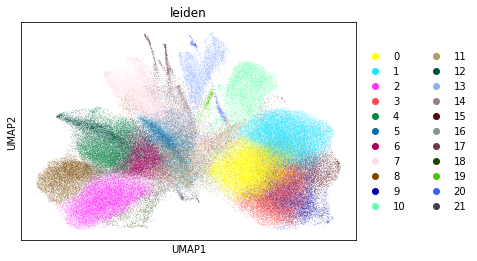

In [50]:
sc.pl.umap(adata, color='leiden')

In [51]:
list(adata.var.index)

['DAPI',
 'CD31',
 'E-cadherin',
 'CD4',
 'CD20',
 'Ki67',
 'CD68',
 'Pan-CK',
 'CD8',
 'Histone H3 Pho',
 'CD163',
 'Podoplanin',
 'CD3',
 'CD36',
 'HIF1a',
 'GLUT1',
 'GATA3',
 'CD45RO',
 'CD45RA',
 'SMA',
 'CK19',
 'MGP',
 'Vimentin',
 'Maspin',
 'Foxp3',
 'MMP9',
 'HLA-DR',
 'CK14',
 'CD11c',
 'CD44']

In [52]:
# adata = adata[:, [True if i != 5 else False for i in range(adata.shape[1])]]
# adata

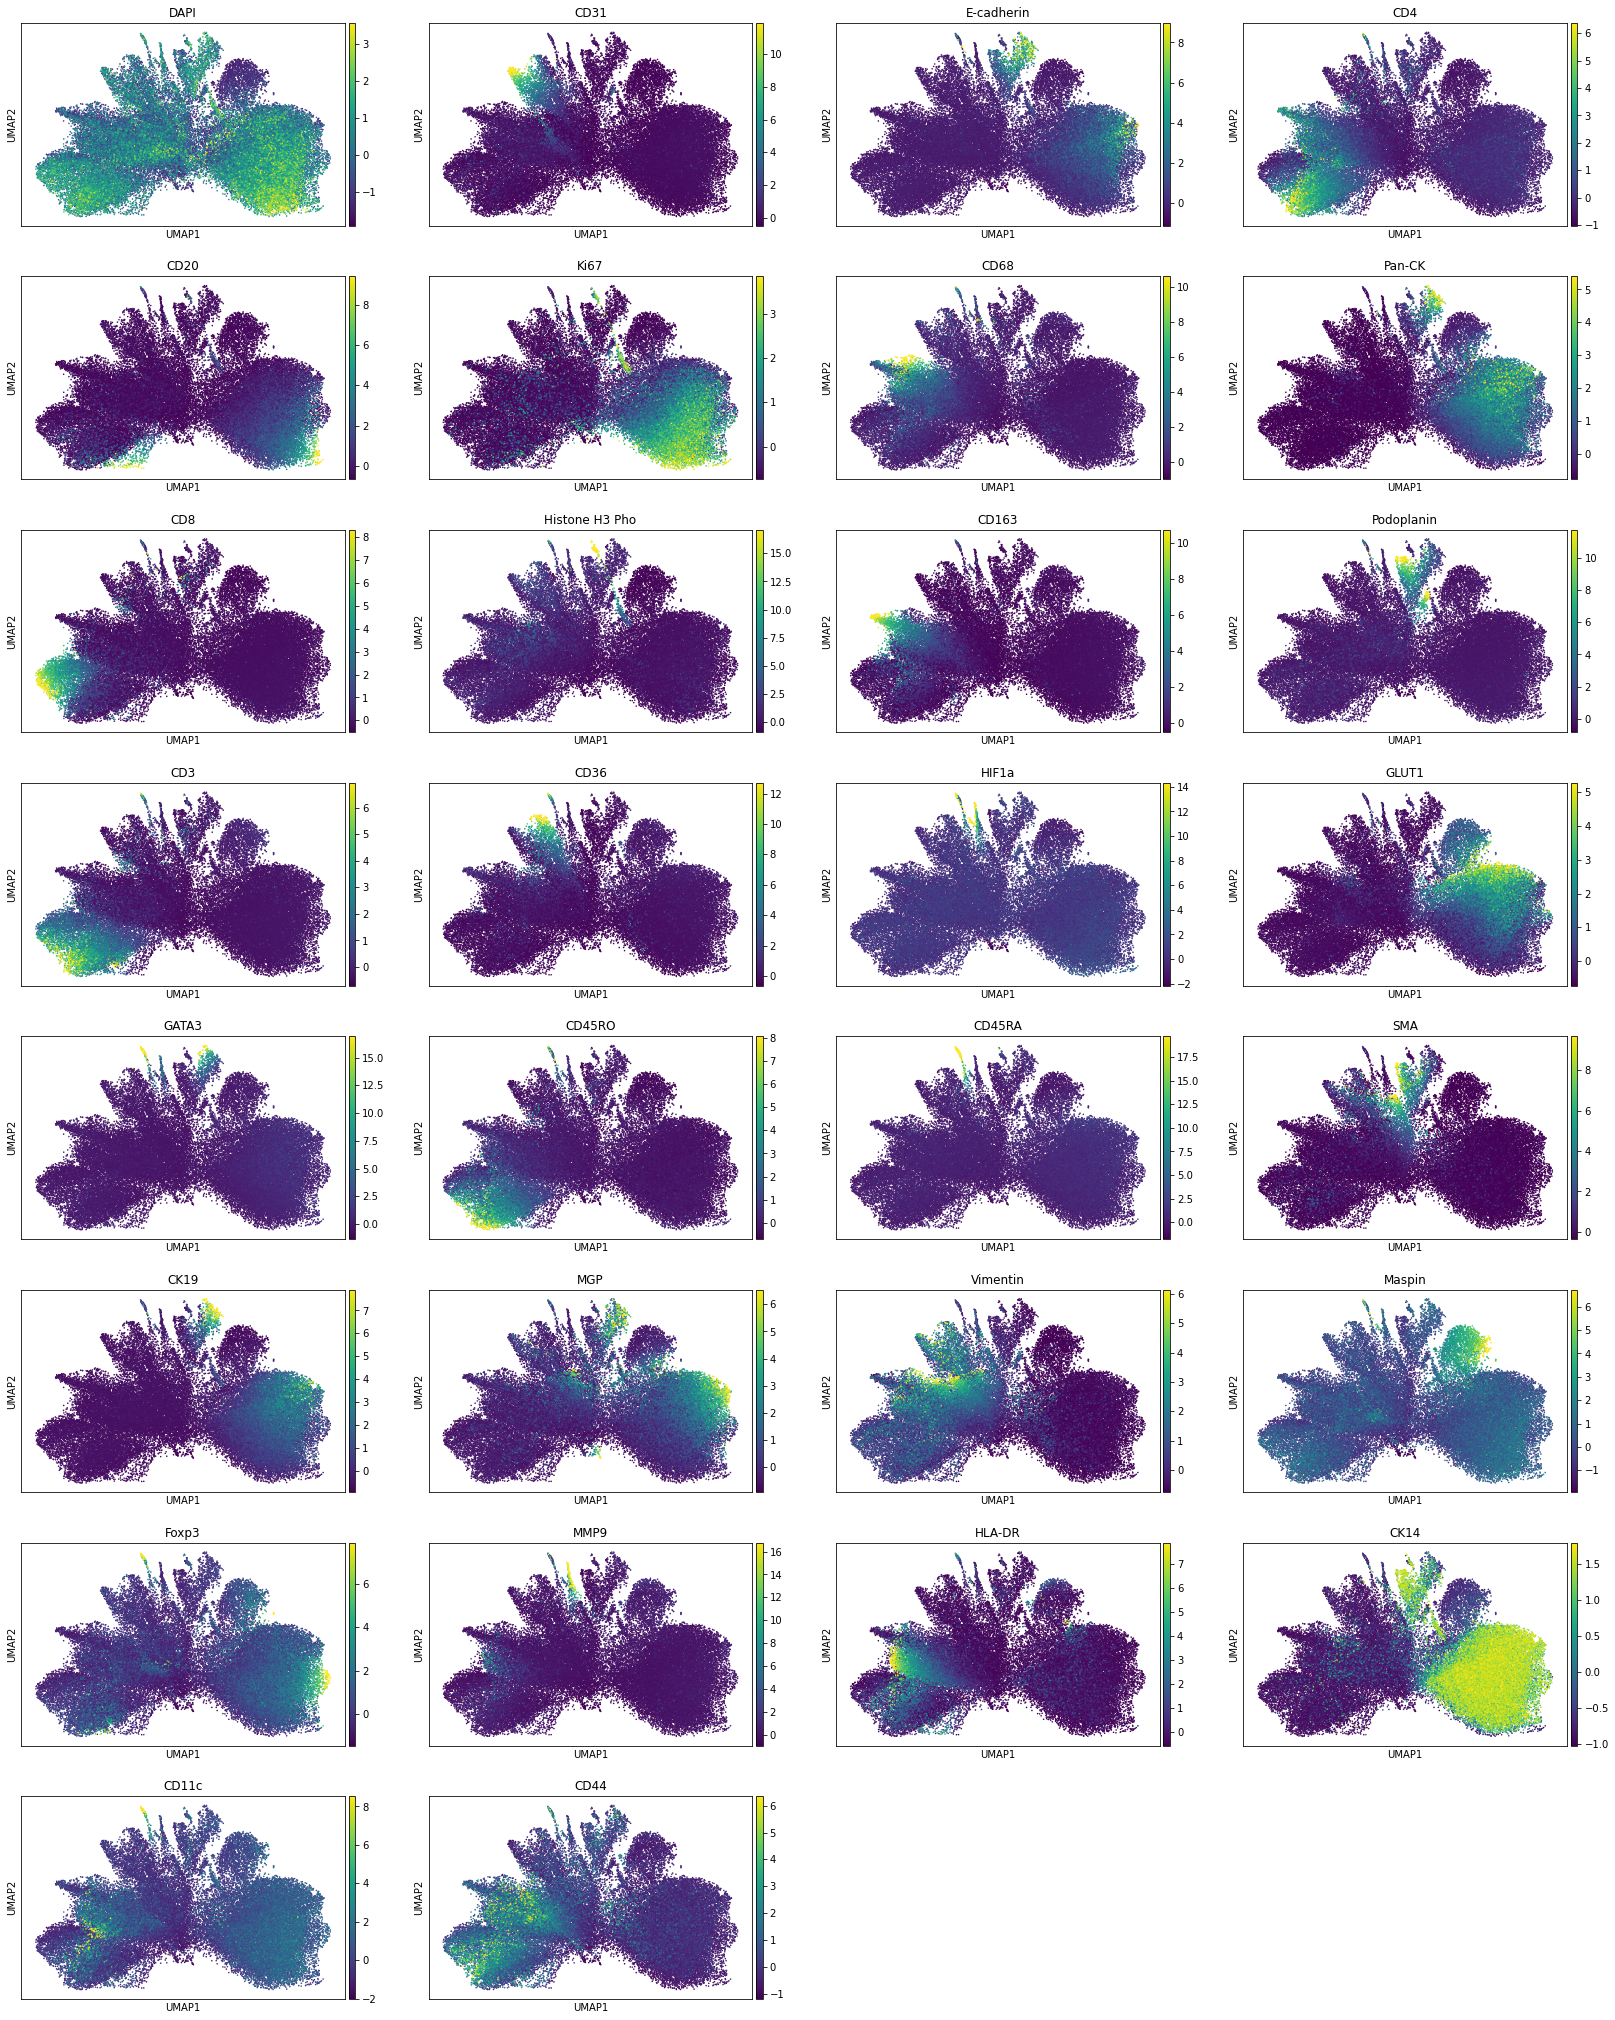

In [53]:
p = adata[np.random.choice(adata.obs.index.to_list(), size=50000, replace=False)]
sc.pl.umap(p, color=[c for c in p.var.index], size=10, save='_marker_umap.png')

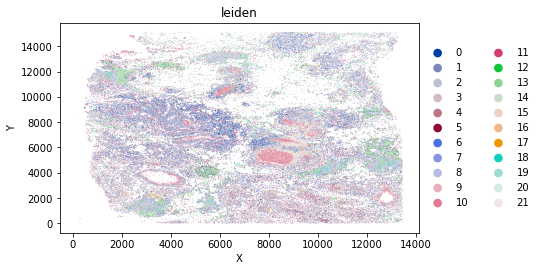

In [54]:
sc.pl.scatter(adata, x='X', y='Y', color='leiden')

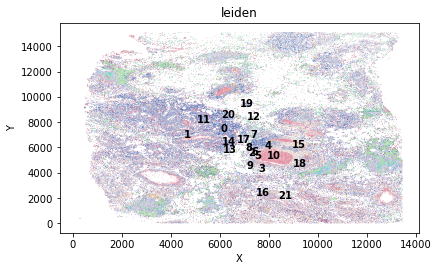

In [55]:
sc.pl.scatter(adata, x='X', y='Y', color='leiden', legend_loc='on data')

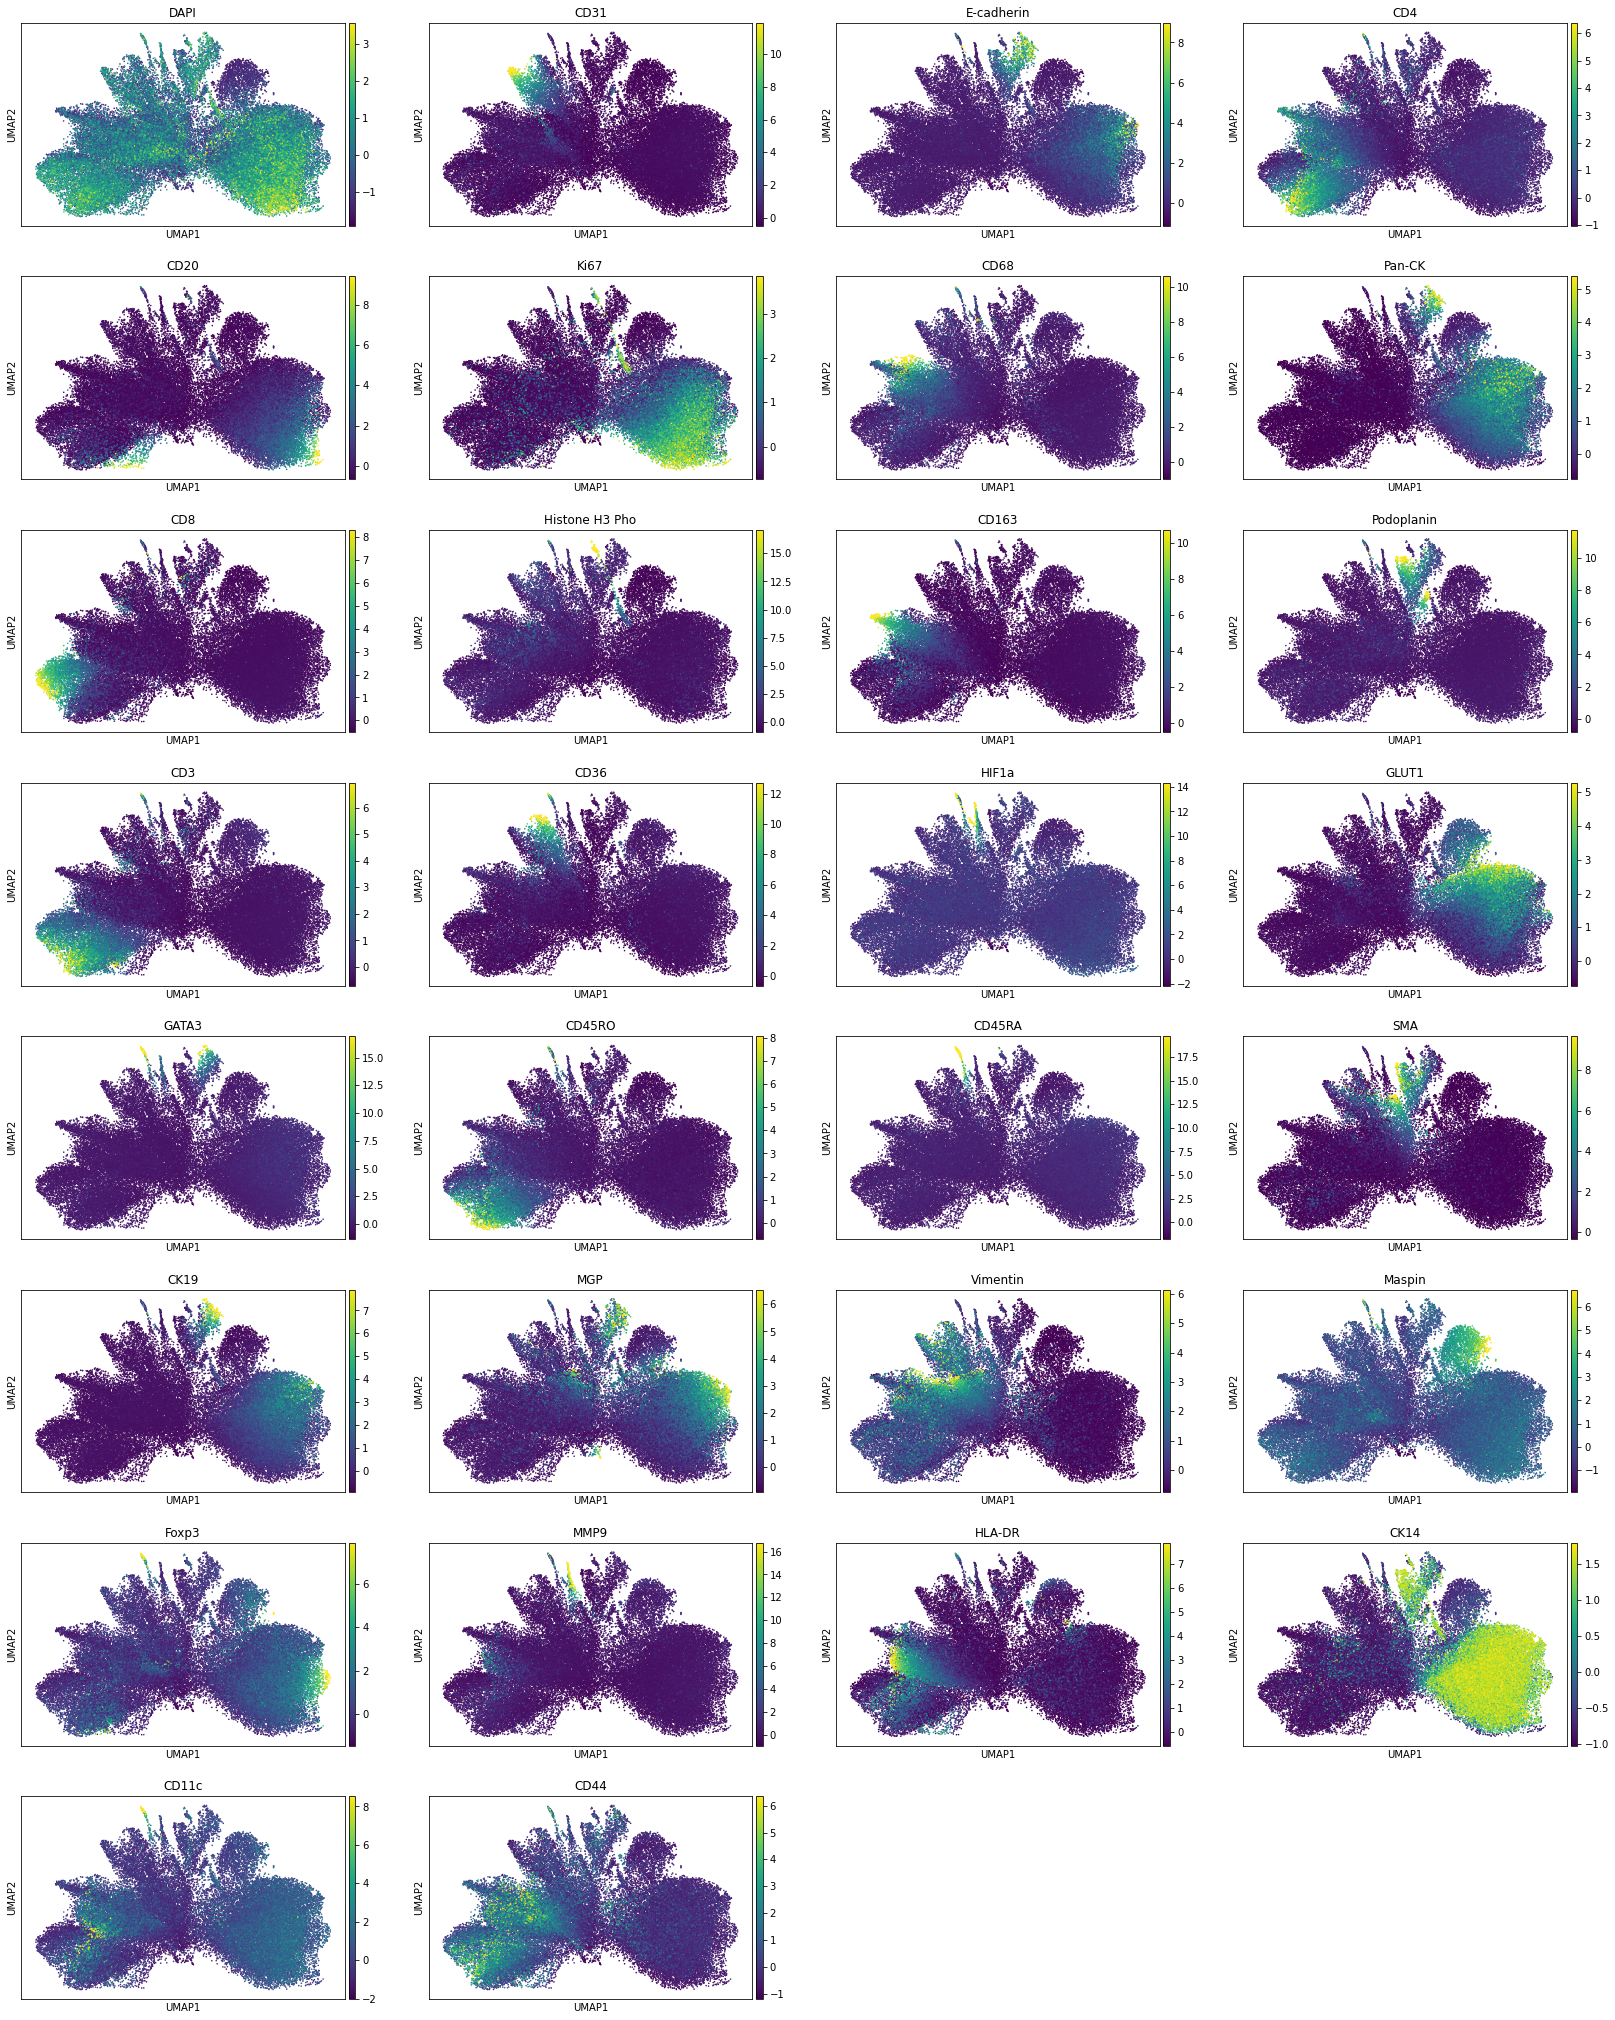

In [56]:
sc.pl.umap(p, color=[c for c in p.var.index], size=10)

Trying to set attribute `._uns` of view, copying.


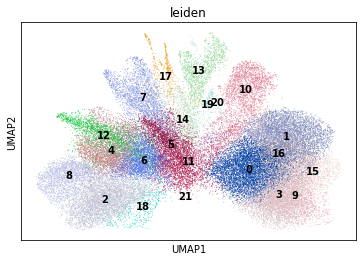

In [57]:
sc.pl.umap(p, color='leiden', legend_loc='on data')

In [60]:
clustermap = {
    'Endothelial': ['7'],
    'Myoepithelial': ['13', '19'],
    'Tumor': ['1', '16', '15', '9', '3', '0'],
    'Macrophage': ['12'],
    'DC': ['4'],
    'B cell': ['18'],
    'Fibroblast': ['6', '5', '11', '21', '14'],
    'CD8 T cell': ['8'],
    'CD4 T cell': ['2'],
}
r = {v:k for k, vs in clustermap.items() for v in vs}
adata.obs['cell type'] = [r[l] if l in r else 'UNK/NOISE'
                          for l in adata.obs['leiden']]

/data/estorrs/miniconda3/envs/segmentation/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell type' as categorical


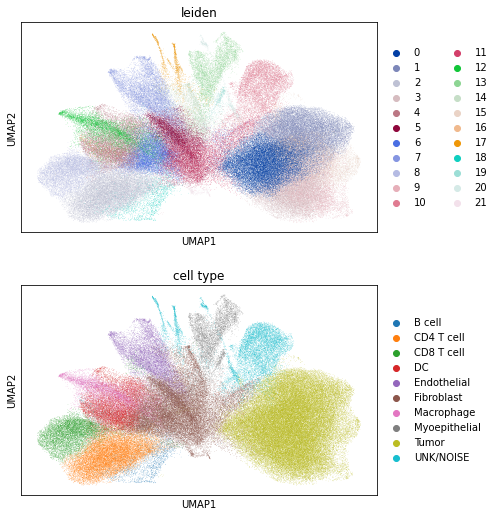

In [61]:
sc.pl.umap(adata, color=['leiden', 'cell type'], save='_cell_types.png', ncols=1)

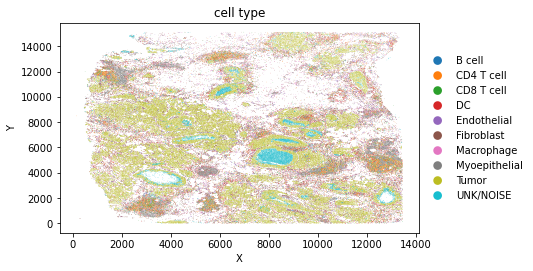

In [72]:
sc.pl.scatter(adata, x='X', y='Y', color='cell type', save='_cell_types_spatial.png')

###### labeling of tumor regions for breast dcis

In [121]:
from skimage.measure import label
from scipy.ndimage.morphology import binary_fill_holes
def label_qitissue_annotation_mask(img):
    filled = binary_fill_holes(img)
    labeled = label(filled)
    return labeled

In [122]:
region_tif = tifffile.imread('/data/multiplex/codex_inhouse/codex/HT206B1-H1/exports/annotation_mask.tif')
adata.uns['annotated_tumor_region_tif'] = label_qitissue_annotation_mask(region_tif)
adata.uns['annotated_tumor_region_tif'].shape

(15120, 13440)

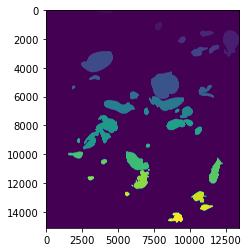

In [123]:
plt.imshow(adata.uns['annotated_tumor_region_tif'])

In [127]:
np.unique(adata.uns['annotated_tumor_region_tif'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35], dtype=int32)

In [124]:
adata.obs['row'] = [int(x) for x in adata.obs['Y']]
adata.obs['col'] = [int(x) for x in adata.obs['X']]
np.max(adata.obs['row']), np.max(adata.obs['col'])

(15117, 13437)

In [129]:
adata.obs['annotated_tumor_region'] = [adata.uns['annotated_tumor_region_tif'][r, c]
                                       for r, c in zip(adata.obs['row'], adata.obs['col'])]
adata.obs

X             Y leiden   cell type    row   col  \
Cell Id                                                              
1        3644.789551      1.421053      1       Tumor      1  3644   
2        3678.917480     17.010118      3       Tumor     17  3678   
3        3728.276367     11.302376      9       Tumor     11  3728   
4        3755.278076     12.594249      1       Tumor     12  3755   
5        3883.165771      8.068571      9       Tumor      8  3883   
...              ...           ...    ...         ...    ...   ...   
175731   9168.000000  15117.500000      0       Tumor  15117  9168   
175732   9217.380859  15117.238281      3       Tumor  15117  9217   
175733   9241.265625  15117.296875     16       Tumor  15117  9241   
175734   4270.210449  15117.579102     12  Macrophage  15117  4270   
175735   6969.500000  15117.599609      8  CD8 T cell  15117  6969   

         annotated_tumor_region  unannotated_tumor_region  region_cell_count  \
Cell Id                                                                        
1                             1                      9097                  1   
2                             1                     10461                  1   
3                             1                      1337                 10   
4                             1                     10460                  1   
5                             1                        29                186   
...                         ...                       ...                ...   
175731                        0                      2581                  5   
175732                        0                      2285                  6   
175733                        0                      2285                  6   
175734                        0                         0                  0   
175735                        0                         0                  0   

         unannotated_region_cell_count  tumor_region  tumor_region_cell_count  
Cell Id                                                                        
1                                    1          9097                        1  
2                                    1         10461                        1  
3                                   10          1337                       10  
4                                    1         10460                        1  
5                                  186            29                      186  
...                                ...           ...                      ...  
175731                               5          2581                        5  
175732                               6          2285                        6  
175733                               6          2285                        6  
175734                               0             0                        0  
175735                               0             0                        0  

[175735 rows x 12 columns]

In [131]:
from sklearn.neighbors import kneighbors_graph, radius_neighbors_graph
from sknetwork.clustering import Louvain
from collections import Counter
def cluster_unannotated_tumor(adata):
    tumor = adata[adata.obs['cell type']=='Tumor']
    tumor = tumor[tumor.obs['annotated_tumor_region']==0]
    adj = radius_neighbors_graph(tumor.obs[['row', 'col']].values, 25., mode='distance')
    louvain = Louvain(resolution=1., )
    labels = louvain.fit_transform(adj) + 1
    id_to_label = {k:l for k, l in zip(tumor.obs.index.to_list(), labels)}
    adata.obs['unannotated_tumor_region'] = [int(id_to_label.get(k, 0)) for k in adata.obs.index.to_list()]
    counts = Counter(adata.obs['unannotated_tumor_region'])
    adata.obs['unannotated_region_cell_count'] = [counts[x] if x is not 0 else 0
                                     for x in adata.obs['unannotated_tumor_region']]
    return adata

In [132]:
adata = cluster_unannotated_tumor(adata)

In [133]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from skimage.draw import polygon2mask

def generate_unannotated_labeled_img(adata, min_cells=20):
    labels = sorted(set(adata[adata.obs['unannotated_region_cell_count']>=min_cells].obs['unannotated_tumor_region']))
    unannotated_label_img = np.zeros(adata.uns['annotated_tumor_region_tif'].shape)
    print(max(labels))
    for i, l in enumerate(labels):
        f = adata[adata.obs['unannotated_tumor_region']==l]
        
        pts = f.obs[['row', 'col']]
        chull = ConvexHull(pts)
        hull_pts = chull.points.astype(int)[chull.vertices]
        unannotated_label_img[polygon2mask(unannotated_label_img.shape, hull_pts)] = l
    adata.uns['unannotated_tumor_region_tif'] = unannotated_label_img
    return adata

In [134]:
adata = generate_unannotated_labeled_img(adata, min_cells=20)

436


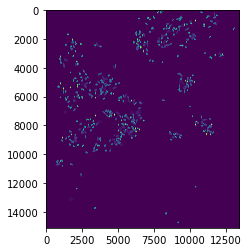

In [135]:
plt.imshow(adata.uns['unannotated_tumor_region_tif'])

In [136]:
def generate_regions(adata):
    annotated_region_map = {k:k for k in np.unique(adata.obs['annotated_tumor_region'])}
    step = max(adata.obs['annotated_tumor_region'])
    unannotated_region_map = {k:k + step
                              for k in np.unique(adata.obs['unannotated_tumor_region'])}
    
    adata.obs['tumor_region'] = [annotated_region_map[k] for k in adata.obs['annotated_tumor_region']]
    adata.obs['tumor_region'] = [unannotated_region_map[ur] if ur > 0 else k
                                for k, ur in zip(adata.obs['tumor_region'], adata.obs['unannotated_tumor_region'])]
    counts = Counter(adata.obs['tumor_region'])
    adata.obs['tumor_region_cell_count'] = [counts[x] if x is not 0 else 0
                                     for x in adata.obs['tumor_region']]
    
    
    
    img = adata.uns['unannotated_tumor_region_tif'].copy()
    for r in range(img.shape[0]):
        for c in range(img.shape[1]):
            if img[r, c] > 0:
                img[r, c] = unannotated_region_map[img[r, c]]
        
    adata.uns['tumor_region_tif'] = adata.uns['annotated_tumor_region_tif'] + img
    
    return adata

In [137]:
adata = generate_regions(adata)

In [138]:
adata.obs

X             Y leiden   cell type    row   col  \
Cell Id                                                              
1        3644.789551      1.421053      1       Tumor      1  3644   
2        3678.917480     17.010118      3       Tumor     17  3678   
3        3728.276367     11.302376      9       Tumor     11  3728   
4        3755.278076     12.594249      1       Tumor     12  3755   
5        3883.165771      8.068571      9       Tumor      8  3883   
...              ...           ...    ...         ...    ...   ...   
175731   9168.000000  15117.500000      0       Tumor  15117  9168   
175732   9217.380859  15117.238281      3       Tumor  15117  9217   
175733   9241.265625  15117.296875     16       Tumor  15117  9241   
175734   4270.210449  15117.579102     12  Macrophage  15117  4270   
175735   6969.500000  15117.599609      8  CD8 T cell  15117  6969   

         annotated_tumor_region  unannotated_tumor_region  region_cell_count  \
Cell Id                                                                        
1                             1                         0                  1   
2                             1                         0                  1   
3                             1                         0                 10   
4                             1                         0                  1   
5                             1                         0                186   
...                         ...                       ...                ...   
175731                        0                      1912                  5   
175732                        0                      1728                  6   
175733                        0                      1728                  6   
175734                        0                         0                  0   
175735                        0                         0                  0   

         unannotated_region_cell_count  tumor_region  tumor_region_cell_count  
Cell Id                                                                        
1                                    0             1                      358  
2                                    0             1                      358  
3                                    0             1                      358  
4                                    0             1                      358  
5                                    0             1                      358  
...                                ...           ...                      ...  
175731                               5          1947                        5  
175732                               6          1763                        6  
175733                               6          1763                        6  
175734                               0             0                        0  
175735                               0             0                        0  

[175735 rows x 12 columns]

In [140]:
adata[adata.obs['annotated_tumor_region']==10]

View of AnnData object with n_obs × n_vars = 370 × 30
    obs: 'X', 'Y', 'leiden', 'cell type', 'row', 'col', 'annotated_tumor_region', 'unannotated_tumor_region', 'region_cell_count', 'unannotated_region_cell_count', 'tumor_region', 'tumor_region_cell_count'
    uns: 'cell type_colors', 'leiden', 'leiden_colors', 'neighbors', 'umap', 'tumor_region_tif', 'annotated_tumor_region_tif', 'unannotated_tumor_region_tif'
    obsm: 'X_umap'
    obsp: 'connectivities', 'distances'

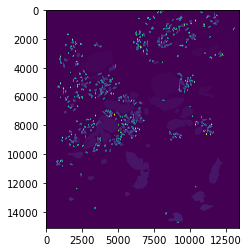

In [141]:
plt.imshow(adata.uns['tumor_region_tif'])

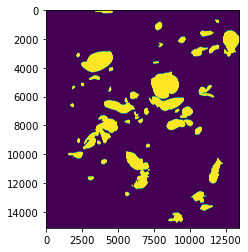

In [145]:
plt.imshow(((adata.uns['tumor_region_tif'] < 50) & (adata.uns['tumor_region_tif'] > 0)))

In [146]:
adata.uns['MGP'] = channel_to_img['MGP']

In [149]:
adata.uns['cell_segmentation_tif'] = tifffile.imread('/data/multiplex/codex_inhouse/codex/HT206B1-H1/exports/ExportedCellSegmentation.tif')

In [150]:
adata.write_h5ad(os.path.join(out_dir, 'processed.h5ad'))

In [151]:
adata.obs.to_csv(os.path.join(out_dir, 'processed_metadata.txt'), index=False, sep='\t')

In [8]:
adata = sc.read_h5ad(os.path.join(out_dir, 'processed.h5ad'))
adata

AnnData object with n_obs × n_vars = 175735 × 30
    obs: 'X', 'Y', 'leiden', 'cell type'
    uns: 'cell type_colors', 'leiden', 'leiden_colors', 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'connectivities', 'distances'

## extras

In [78]:
import scipy.spatial as spatial

d = 40.

centers = [(x, y) for x, y in zip(adata.obs['X'], adata.obs['Y'])]

point_tree = spatial.cKDTree(centers)

pt_to_neighbors = {}
for i, pt in enumerate(centers):
    pt_to_neighbors[i] = [x for x in point_tree.query_ball_point(pt, d) if x!=i]


In [79]:
# get associations
col = 'cell type'
assocs = {g:{k:0 for k in set(adata.obs[col])} for g in set(adata.obs[col])}
for k, vals in pt_to_neighbors.items():
    for v in vals:
        assocs[adata.obs[col][k]][adata.obs[col][v]] += 1

In [80]:
import seaborn as sns

In [81]:
from collections import Counter
counts = Counter(adata.obs['cell type'])

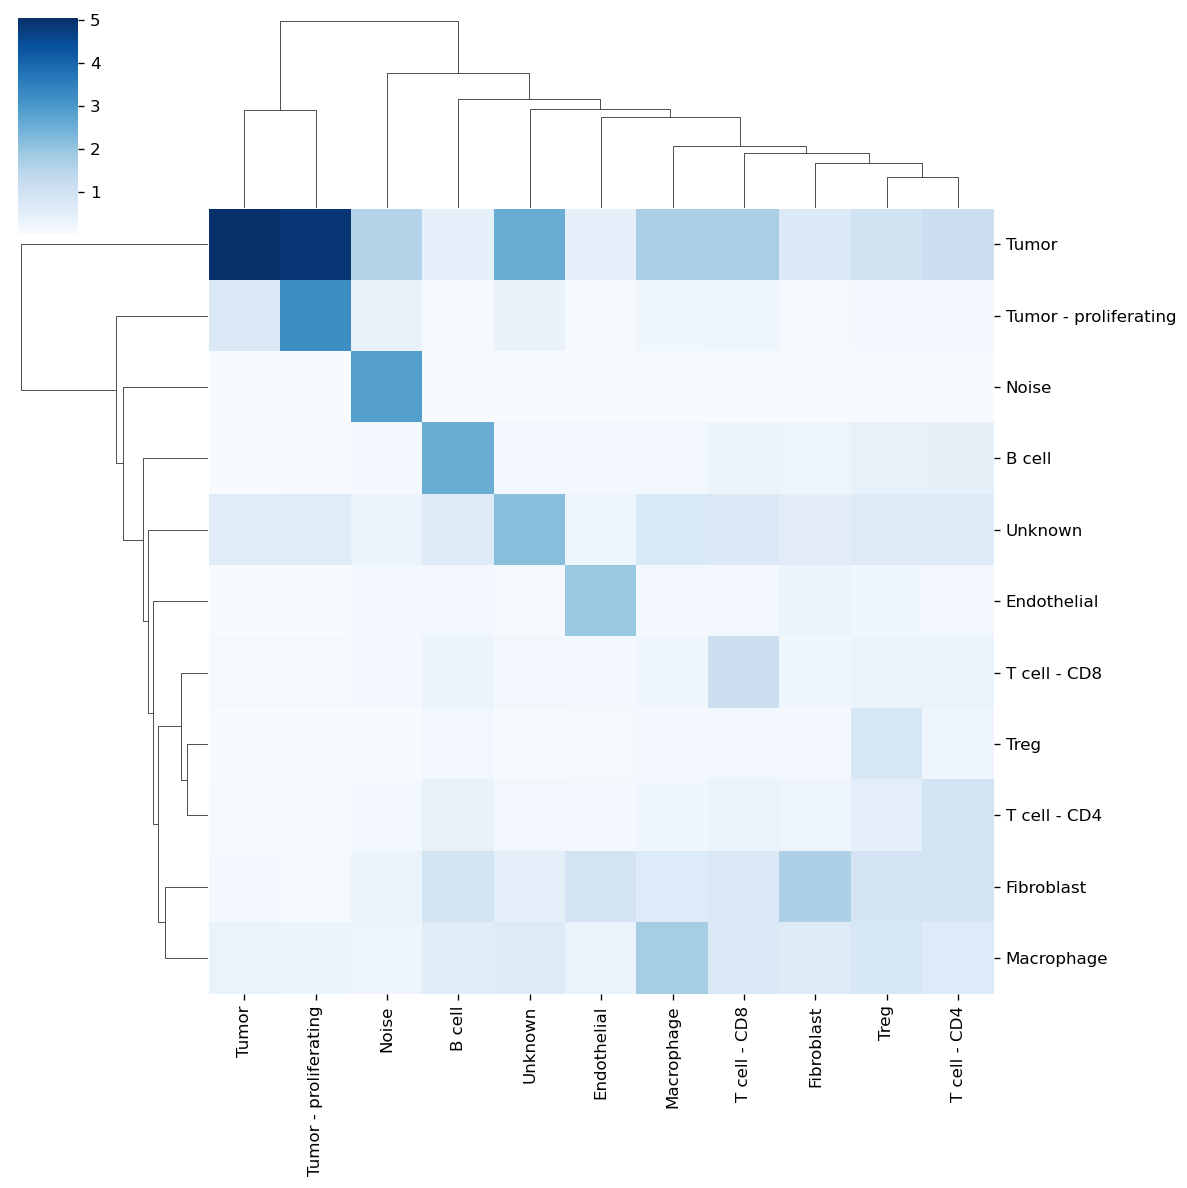

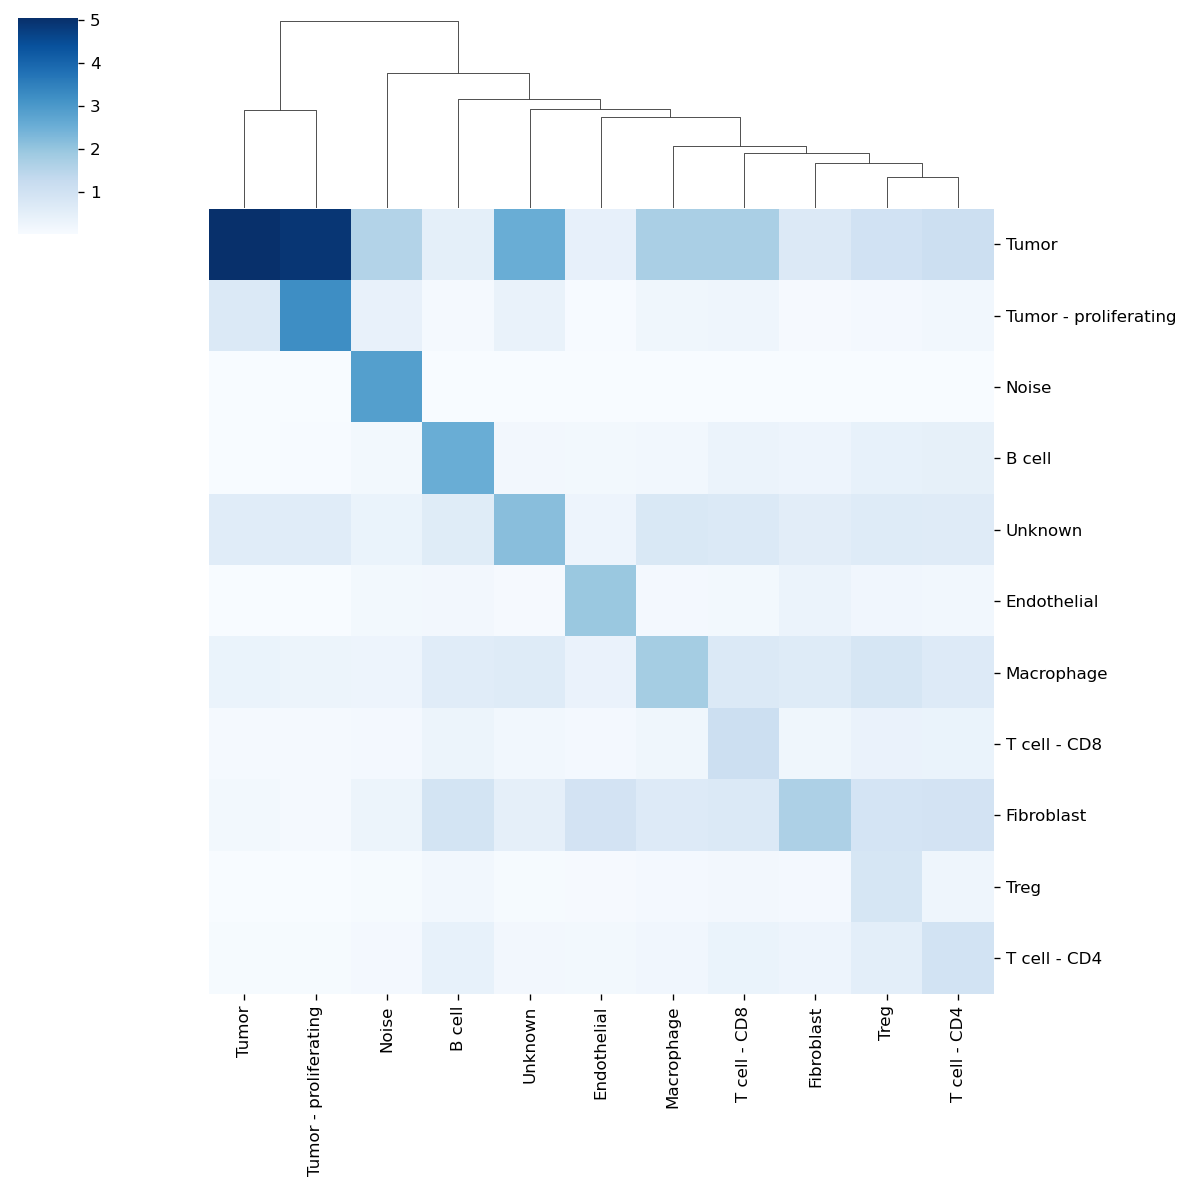

In [82]:
assocs = pd.DataFrame.from_dict(assocs)
# assocs = assocs / np.sum(assocs, axis=1)
assocs = assocs / np.asarray([counts[x] for x in assocs.columns])
# assocs = pd.DataFrame(data=np.log1p(assocs.values), columns=assocs.columns, index=assocs.index)
cg = sns.clustermap(assocs, cmap='Blues', row_cluster=True)
assocs = assocs.iloc[cg.dendrogram_col.reordered_ind]
sns.clustermap(assocs, cmap='Blues', row_cluster=False,)

In [83]:
assocs

Tumor      Treg  Endothelial    B cell   Unknown  \
Tumor                  5.056677  0.995355     0.432327  0.510452  2.561651   
Tumor - proliferating  0.744512  0.121622     0.045963  0.112729  0.380924   
Noise                  0.021257  0.038007     0.027646  0.033035  0.020213   
B cell                 0.031700  0.431166     0.142639  2.570735  0.165258   
Unknown                0.600790  0.663007     0.291045  0.624113  2.177020   
Endothelial            0.029544  0.206926     1.962008  0.156962  0.084804   
Macrophage             0.343784  0.863176     0.356852  0.602650  0.666271   
T cell - CD8           0.101138  0.364020     0.126018  0.307391  0.183395   
Fibroblast             0.143165  0.921453     0.952171  0.937290  0.481789   
Treg                   0.027319  0.849662     0.083107  0.190556  0.077588   
T cell - CD4           0.065648  0.527449     0.154681  0.423292  0.157697   

                          Noise  T cell - CD4  T cell - CD8  Fibroblast  \
Tumor                  1.578313      1.135298      1.715016    0.711275   
Tumor - proliferating  0.394148      0.192423      0.273978    0.086491   
Noise                  2.889845      0.029064      0.029285    0.020903   
B cell                 0.152324      0.454600      0.323703    0.289186   
Unknown                0.351979      0.639607      0.729363    0.561384   
Endothelial            0.140275      0.182802      0.146030    0.323275   
Macrophage             0.277108      0.680698      0.738994    0.666475   
T cell - CD8           0.128227      0.342153      1.135613    0.217955   
Fibroblast             0.312392      0.958308      0.743907    1.681562   
Treg                   0.077453      0.250351      0.169418    0.125648   
T cell - CD4           0.124785      0.969733      0.335495    0.275308   

                       Macrophage  Tumor - proliferating  
Tumor                    1.712727               4.936976  
Tumor - proliferating    0.229876               3.234955  
Noise                    0.018593               0.035201  
B cell                   0.186453               0.046422  
Unknown                  0.778496               0.592422  
Endothelial              0.121492               0.020829  
Macrophage               1.802864               0.305972  
T cell - CD8             0.217115               0.107140  
Fibroblast               0.668322               0.115441  
Treg                     0.118027               0.022135  
T cell - CD4             0.196097               0.073784